# Кто выжил на Титанике

Крушение Титаника - одно из самых печально известных кораблекрушений в истории.

15 апреля 1912 года во время своего первого рейса широко известный «непотопляемый» Титаник затонул после столкновения с айсбергом. К сожалению, на борту не хватило спасательных шлюпок на всех, в результате чего погибли 1502 человека из 2224 пассажиров и членов экипажа.

Хотя в выживании был определенный элемент удачи, похоже, что некоторые группы людей выживали с большей вероятностью, чем другие.

В этой задаче нужно построить прогностическую модель, которая отвечает на вопрос: «Какие люди выживут с большей вероятностью?» с использованием данных о пассажирах (например, имя, возраст, пол, социально-экономический класс и т.д.).

На основе обучающего набора выборок, в котором перечислены пассажиры, которые выжили или не выжили в катастрофе, может ли наша модель определить, выжили ли пассажиры в тестовом наборе данных не содержащем информации о выживании.

In [ ]:
# для анализа данных
import pandas as pd
import numpy as np
import random as rnd

# для визуализации
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# для машинного обучения
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

## Загрузим данные и проанализируем

In [ ]:
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')
combine = [df_train, df_test]  # Комбинируем два датасета для выполнения определенных действий над двумя массивами

In [ ]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Что значать сокращения!

Survived - выжил или нет

Pclass: показатель социально-экономического статуса (SES).
*  1-й = высокий
*  2-й = средний
*  3-й = низкий

SibSp: Набор данных определяет семейные отношения следующим образом:
*  Sibling = брат, сестра, сводный брат, сводная сестра
*  Spouse = муж, жена (любовницы и женихи игнорировались)

Parch: Набор данных определяет семейные отношения следующим образом:
*  Родитель = мать, отец
*  Ребенок = дочь, сын, падчерица, пасынок
*  Некоторые дети путешествовали только с няней, поэтому для них parch = 0.

Fare - Пасажирский тариф

Cabin - Номер каюты

Embarked - Порт в котором пассажир сел на рейс
*  C = Cherbourg
*  Q = Queenstown
*  S = Southampton

На основе этой таблицы давайте по рассуждаем:

**В каких данных можно выделить явные категории?**

> Эти значения помогут нам классифицировать данные по схожим наборам. Например: Survived, Sex, and Embarked. Очевидно, что этих пассажиров можно сгрупировать.

**Какие данные числовые?**

> Под числовыми имеется в виду какие-либо переменные цифровые значения, например: Age, Fare. или в какой-то степени SibSp, Parch.

> Survived - в эту категорию не попадет, хотя и тоже цифровое значение, оно в данном случае больше бинарное.

**Какие данные относятся к смешанным типам данных?**

> Числовые, буквенно-цифровые данные внутри одного объекта.

> Такие данные необходимо будет откоректировать или удалить. Например: Билет представляет собой сочетание числовых и буквенно-цифровых типов данных, Номер каюты - буквенно-цифровая.

**Какие данные могут содержать ошибки или опечатки?**

> В большом наборe данных это сложно распознать, однако просмотр нескольких выборок из меньшего набора данных может подсказать нам, какие данные могут потребовать исправления.

> В данном случае, колонка с именем Name может содержать ошибки или опечатки, поскольку существует несколько способов написания имени, включая заголовки, приставки, круглые скобки и кавычки.

**Какие данные содержат пустые или нулевые значения?**

> В эти данные нужно будет внести исправления. Например «Каюта» содержит ряд нулевых значений.

**Какой тип данных у различных столбцов?**

> Помогает при сравнение и преобразовании выборок

> Например: Семь серий являются целочисленными или плавающей точкой. И шесть в случае тестового набора данных.

In [ ]:
df_train.info()
print('_' * 50)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
__________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0  

## Какое распределение числовых значений по выборкам?

Это поможет узнать насколько репрезентативен обучающий набор данных для реальной проблемной области.

* Выборка составляют 891 человек или 40% от фактического количества пассажиров на борту Титаника (2224 человека).

* Survived - это категориальный признак со значениями 0 или 1.

* Около 38% образцов выжили, что соответствует фактической выживаемости 32%.

* Большинство пассажиров (> 75%) не путешествовали с родителями или детьми.

* Почти у 30% пассажиров на борту были братья, сестры и/или супруги.

* Стоимость проезда значительно различалась: часть пассажиров (<1%) платили до 512 долларов.

* Часть пассажиров были пожилого возраста (<1%) в возрасте от 65 до 80 лет.

In [ ]:
df_train.describe()
# Просмотрите процент выживаемости, используя `percentiles = [.61, .62]`,
# зная, что в нашем описании проблемы упоминается коэффициент выживаемости 38%.
# Просмотрите распределение Parch, используя `percentiles = [.75, .8]`
# Распределение SibSp `[.68, .69]`
# Возраст и тариф `[.1, .2, .3, .4, .5, .6, .7, .8, .9, .99]`

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Каково распределение категориальных признаков?

* Имена, которые уникальны в наборе данных (count = unique = 891)

* Значения Sex принимают два возможных значения, где 65% мужчин.

* Значения Cabin имеют несколько дубликатов в выборках. В качестве альтернативы несколько пассажиров жили в одной каюте.

* Embarked принимает три возможных значения. Значени S используется большинством пассажиров.

* Данные билетов имеет высокий процент (22%) повторяющихся значений (уникальность = 681).

In [ ]:
df_train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


## Предположения, основанные на анализе данных
На основе проведенного анализа данных мы приходим к следующим предварительным действиям, которотые можно дополнительно проверить.

1. Необходимо узнать, насколько хорошо каждый критерий соотносится с выживанием. Например, влияент ли, имя на его выживаемость.  
Нужно простым способом сделать предварительных прогноз, а потом сравнить с результатом модели.

2. Наверно нужно указать заполнить пропущенные данные например в возрасте, поскольку он определенно связан с выживанием.

3. Информация о билетах может быть исключена из нашего анализа, поскольку она содержит большое количество дубликатов и может не быть зависимости между билетом и выживаемостью. Также PassengerId может быть исключен из набора обучающих данных, поскольку он не способствует выживанию.

4. Нам нужно создать новый столбец под названием Family на основе Parch и SibSp, чтобы получить общее количество членов семьи на борту.
Возможно, мы захотим спроектировать столбец Name для извлечения Title в качестве новой функции.
Может быть, нужно создать новый столбец для возрастных групп. Это превратит непрерывный числовой признак в порядковый категориальный признак.

5. Также можно предположить, основываясь на описании проблемы, упомянутом ранее, что:
* Женщины имели больше шансов выжить.
* Дети (возраст < ? ) имели больше шансов выжить.
* Пассажиры высшего класса (Pclass = 1) с большей вероятностью выживали






---
## Анализ c помощью групировки и агригации

Чтобы подтвердить некоторые из наших наблюдений и предположений, мы можем быстро проанализировать корреляцию между данными, сравнивая их друг с другом.

> Имеет смысл делать это только для данных категориального (Sex), порядкового (Pclass) или дискретного (SibSp, Parch) типа.(Pclass) или дискретного (SibSp, Parch) типа.

In [ ]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


> Мы наблюдаем значительную корреляцию (> 0,5) между Pclass = 1 и Survived поэтому наверно нужно включить эти данные в нашу модель.

In [ ]:
df_train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


> Явно подтверждается наблюдение, что женщины выживают больше (74%)

In [ ]:
df_train[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [ ]:
df_train[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


> `SibSp и Parch` Эти данные не имеют какой либо определенной зависимости возможно имеет смысл объединить их в одну общую группу "Семья".

---
## Анализ c помощью визуализации данных

Теперь можно посмотреть и подтвердить гипотезы графиками

### Корреляция числовых характеристик

> Начнем с понимания зависимости между числовыми характеристиками и нашей целью решения (выживанием).

Гистограмма может отображать распределение выборок с использованием автоматически определенных интервалов или полос с одинаковым диапазоном. Это поможет ответить на вопросы, относящиеся к конкретным группам. Например, была ли у младенцев более высокая выживаемость?

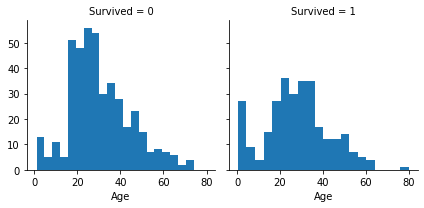

In [ ]:
g = sns.FacetGrid(df_train, col='Survived')
g.map(plt.hist, 'Age', bins=20)

## И так!

 - Дети до четырех лет  - выживали.
 - Старички (возраст = 80) выжили.
 - Большое количество молодежи (15-25 лет) не выжило.
 - В основном пассажиры находятся в возрастном диапазоне от 15 до 35 лет.

Этот простой анализ подтверждает наши предположения  и для последующих этапов рабочего процесса мы должны:

* Учитывать возраст в нашем обучении модели.
* Заполните нулевые значения для возраста.
* И объединить возрастные группы.

---
### Соотношение числовых и порядковых признаков

Мы можем комбинировать несколько функций для выявления корреляций, используя один график. Это можно сделать с помощью числовых и категориальных функций, которые имеют числовые значения.

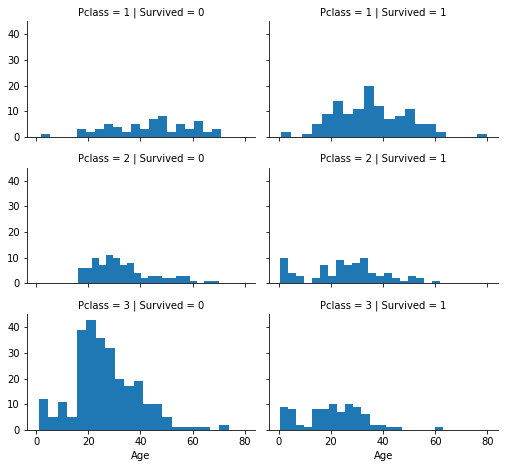

In [ ]:
grid = sns.FacetGrid(df_train, col='Survived', row='Pclass', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=1.0, bins=20)
grid.add_legend();

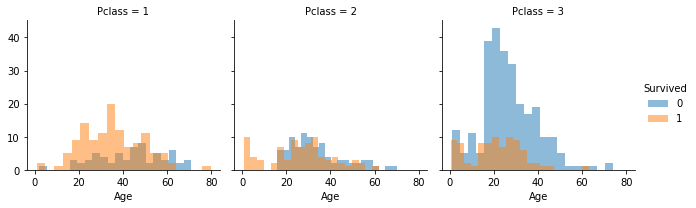

In [ ]:
grid = sns.FacetGrid(df_train, col='Pclass', hue='Survived')
grid.map(plt.hist, 'Age', alpha=0.5, bins=20)
grid.add_legend();

### Что мы видим:
* Большинство пассажиров было в Pclass = 3, однако большинство из них не выжило.
* Маленькие дети в Pclass = 2 и Pclass = 3 в основном выжили.
* Большинство пассажиров Pclass = 1 выжили.
* Pclass зависит от возраста пассажиров.

---
### Соотношения категориальных признаков

Теперь мы можем соотнести категориальные особенности с нашей целью решения.

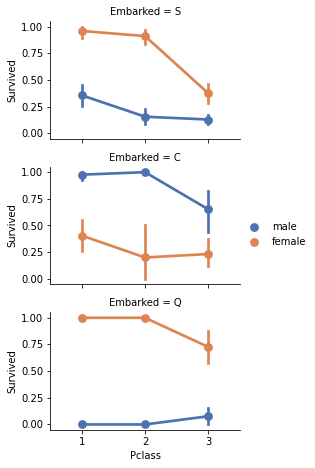

In [ ]:
grid = sns.FacetGrid(df_train, row='Embarked', height=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep', order=None, hue_order=None)
grid.add_legend()

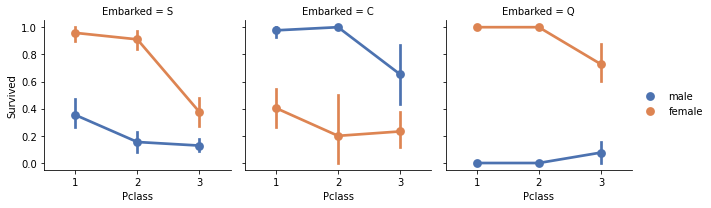

In [ ]:
grid = sns.FacetGrid(df_train, col='Embarked')
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep', order=None, hue_order=None)
grid.add_legend()

#### Наблюдения.

 - Выживаемость женщин была намного выше, чем у мужчин.
 - Исключение составляет Embarked = C, где у мужчин была более высокая выживаемость. Поэтому может быть корреляция между Pclass и Embarked и, в свою очередь, Pclass и Survived, но не обязательно прямая корреляция между Embarked и Survived.
 - Мужчины имели лучшую выживаемость при Pclass = 3 по сравнению с Pclass = 2 для Embarked C и Q.
 - Embarked предпологает разную выживаемость для пассажиров Pclass = 3 и мужчин.

#### Выводы.

 - Добавим колонку Sex в обучение модели.
 - Заполним и добавим данные Embarked для обучения модели.

---
### Соотношение категориальных и числовых признаков

Давайте рассмотрим возможные зависимости между категориальными и числовыми характеристикаи, а именно сравним Embarked (категориальные нечисловые), Sex (категориальные нечисловые), Fare (числовые непрерывные) с выживаемостью Survived (категориальные числовые).

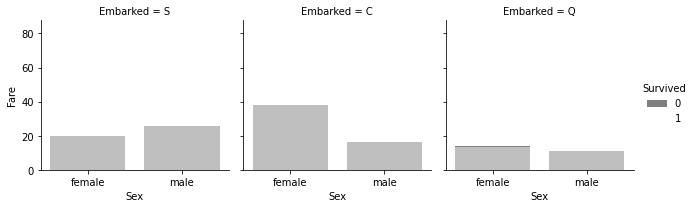

In [ ]:
grid = sns.FacetGrid(df_train, col='Embarked', hue='Survived', palette={0: 'k', 1: 'w'})
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None, order=None)
grid.add_legend()

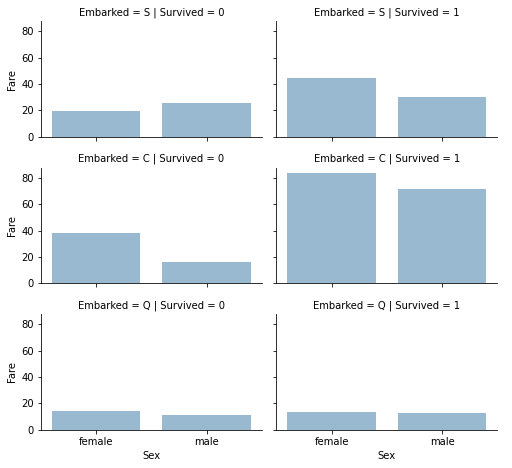

In [ ]:
grid = sns.FacetGrid(df_train, row='Embarked', col='Survived', height=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None, order=None)
grid.add_legend()

### Какие выводы можно сделать.

 - Пассажиры с более высокой оплатой проезда лучше выживали.
 - Порт посадки пассажира как-то связан с показателями выживаемости.

Давайте расмотрим возможность групирования тарифов оплаты проезда.

---
### Обработка данных

> До сих пор  нам не нужно было изменять данные или значения, чтобы провести анализ.
>
> На основе исходных данных мы выдвинули несколько предположений отностительно наших данных. Давайте теперь обработаем наши данные в соответствие с нашими гипотезами.

#### Исправление путем отбрасывания данных

> Начнем обработку с отбрасывания лишних данных, которые не имеют ценности для достижения нашей цели. Это ускорит работу нашей программыи упростит анализ.

> Ранее мы уже выдвинули предположение, что Номер каюты и билеты нам не нужны, потому что много дублирующихся и отсутствующих данных.

> Обратите внимание, что там, где это применимо, мы выполняем операции с наборами данных для обучения и тестирования вместе, чтобы входные параметры были одинаковыми.

In [ ]:
print("Before", df_train.shape, df_test.shape, combine[0].shape, combine[1].shape)

df_train = df_train.drop(['Ticket', 'Cabin'], axis=1)
df_test = df_test.drop(['Ticket', 'Cabin'], axis=1)
combine = [df_train, df_test]

print("After", df_train.shape, df_test.shape, combine[0].shape, combine[1].shape)

Before (891, 12) (418, 11) (891, 12) (418, 11)
After (891, 10) (418, 9) (891, 10) (418, 9)


---
### Создание нового объекта На основе существующих

Если посмотреть на столбец Name в нашей выборке, то можно отметить, помимо имени там указан некая приставка, обозначающая социальный статус (Miss, Mr, Don, Dr и т.д.)


Поэтому было бы не плохо посмотреть зависит ли выживаемость от статуса пассажира, прежде чем удалить из анализируемой выборки Name и PassengerId.


В следующем коде мы извлекаем приставку с помощью регулярных выражений. Шаблон RegEx (\w + \.) соответствует первому слову, которое заканчивается точкой в стобце имени. Флаг expand = False возвращает DataFrame.


In [ ]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(df_train['Title'], df_train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


Далее можно заменить некоторые заголовки на более распространенные или классифицировать их как Rare.

In [ ]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

df_train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


Так же давайте преобразуем текстовые значения в цифровые.

In [ ]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


Теперь мы можем безопасно исключить колонку Name из наборов данных для обучения и тестирования. Нам также не нужна колонка PassengerId в наборе обучающих данных.

In [ ]:
df_train = df_train.drop(['Name', 'PassengerId'], axis=1)
df_test = df_test.drop(['Name'], axis=1)
combine = [df_train, df_test]
df_train.shape, df_test.shape

((891, 9), (418, 9))

### Преобразование категориального признака

Теперь необходимо преобразовать объекты, содержащие строки, в числовые значения. Это требуется для большинства алгоритмов модели.

Преобразуем  значения male (female), где присвоем цифровые значения

* женский = 1
* мужской = 0.

In [ ]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


---
### Заполнение числового непрерывного признака

Теперь мы должны оценить и дополнить данные с отсутствующими или нулевыми значениями. Сначала мы сделаем это для функции "Возраст".

Мы можем рассмотреть три метода для заполнения числовых непрерывных данных.

1. Простой способ - сгенерировать случайные числа между средним и стандартным отклонением.

2. Более точный способ угадать недостающие значения - используя другие коррелированные данные. В нашем случае мы отмечаем корреляцию между возрастом, полом и классом. Угадать значения возраста, используя медианные значения возраста по наборам комбинаций данных Pclass и Sex.

> Например, средний возраст для Pclass = 1 и Sex = 0, Pclass = 1 и Sex = 1 и так далее ...

3. Объединить методы 1 и 2. Поэтому вместо того, чтобы угадывать значения возраста на основе медианы, используйте случайные числа между средним и стандартным отклонением на основе наборов комбинаций Pclass и Sex.

> Методы 1 и 3 вводят в наши модели случайный шум. Результаты нескольких выполнений могут отличаться. Мы предпочтем способ 2.

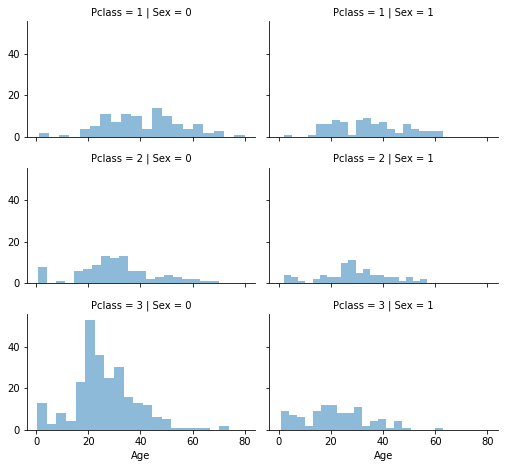

In [ ]:
grid = sns.FacetGrid(df_train, row='Pclass', col='Sex', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

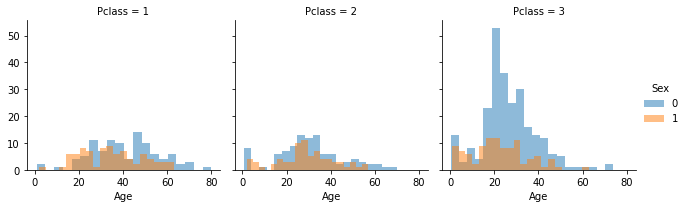

In [ ]:
grid = sns.FacetGrid(df_train, col='Pclass', hue='Sex')
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

Давайте начнем с подготовки пустого массива, который будет содержать предполагаемые значения возраста на основе комбинаций Pclass x Sex.

In [ ]:
guess_ages = np.zeros((2,3))
guess_ages

array([[0., 0., 0.],
       [0., 0., 0.]])

Теперь мы перебираем Sex (0 или 1) и Pclass (1, 2, 3), чтобы вычислить предполагаемые значения Age для шести комбинаций.

In [ ]:
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5

    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1
1,1,1,1,38,1,0,71.2833,C,3
2,1,3,1,26,0,0,7.9250,S,2
3,1,1,1,35,1,0,53.1000,S,3
4,0,3,0,35,0,0,8.0500,S,1


Давайте создадим группы возрастов и определим корреляции с Survived.

In [ ]:
df_train['AgeBand'] = pd.cut(df_train['Age'], 5)
df_train[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


Заменим Age порядковыми числами на основе этих бэндов.

In [ ]:
for dataset in combine:
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,0,3,0,1,1,0,7.2500,S,1,"(16.0, 32.0]"
1,1,1,1,2,1,0,71.2833,C,3,"(32.0, 48.0]"
2,1,3,1,1,0,0,7.9250,S,2,"(16.0, 32.0]"
3,1,1,1,2,1,0,53.1000,S,3,"(32.0, 48.0]"
4,0,3,0,2,0,0,8.0500,S,1,"(32.0, 48.0]"


Теперь мы можем удалить функцию AgeBand

In [ ]:
df_train = df_train.drop(['AgeBand'], axis=1)
combine = [df_train, df_test]
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,1
1,1,1,1,2,1,0,71.2833,C,3
2,1,3,1,1,0,0,7.9250,S,2
3,1,1,1,2,1,0,53.1000,S,3
4,0,3,0,2,0,0,8.0500,S,1


### Создадим новую колонку, объединяющую существующие данные

Мы можем создать новую аолонку FamilySize, которая объединяет Parch и SibSp. Это позволит нам удалить Parch и SibSp из наших наборов данных.

In [ ]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

df_train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


Создадим еще одну колонку под названием IsAlone.

In [ ]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

df_train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


Теперь удалим все промежуточные столбцы Parch, SibSp и FamilySize и оставим IsAlone, т.е. человек с семьей или один.

In [ ]:
df_test

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,IsAlone
0,892,3,0,2,0,0,7.8292,Q,1,1,1
1,893,3,1,2,1,0,7.0000,S,3,2,0
2,894,2,0,3,0,0,9.6875,Q,1,1,1
3,895,3,0,1,0,0,8.6625,S,1,1,1
4,896,3,1,1,1,1,12.2875,S,3,3,0
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,0,1,0,0,8.0500,S,1,1,1
414,1306,1,1,2,0,0,108.9000,C,5,1,1
415,1307,3,0,2,0,0,7.2500,S,1,1,1
416,1308,3,0,1,0,0,8.0500,S,1,1,1


In [ ]:
df_train = df_train.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
df_test = df_test.drop(['Parch', 'SibSp','FamilySize'], axis=1)
combine = [df_train, df_test]

df_train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,7.2500,S,1,0
1,1,1,1,2,71.2833,C,3,0
2,1,3,1,1,7.9250,S,2,1
3,1,1,1,2,53.1000,S,3,0
4,0,3,0,2,8.0500,S,1,1


Также создадим колонку, объединящую Pclass и Age.

In [ ]:
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

df_train.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
5,3,1,3
6,3,3,1
7,0,0,3
8,3,1,3
9,0,0,2


---
## Заполнение категориальных данных

Колонка «Embarked» принимает значения S, Q, C в зависимости от порта посадки. В нашем наборе обучающих данных два пропущенных значения. Мы просто заполняем их наиболее частыми случаями.

In [ ]:
freq_port = df_train.Embarked.dropna().mode()[0]
freq_port

'S'

In [ ]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)

df_train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


### Преобразование категориального признака в числовой

И снова избавляемся от текста и преобразуем категориальный признак в числовой.

Преобразуем функцию Embarked заполнив её числами обозначения порта вместо букв S, Q, C.

In [ ]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

df_train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,7.2500,0,1,0,3
1,1,1,1,2,71.2833,1,3,0,2
2,1,3,1,1,7.9250,0,2,1,3
3,1,1,1,2,53.1000,0,3,0,2
4,0,3,0,2,8.0500,0,1,1,6


### Быстрое заполнение и преобразование числового объекта

Теперь нужно заполнить одно пропущенное значение в тестовом наборе данных Fare.
Поскольку у нас нужно заполнить только одно значение, мы добавляем туда наиболее часто встречающееся для этих данных. Цель этого заполнения заключается в том чтобы выполнить требования к алгоритму модели для работы с ненулевыми значениями.

Мы также можем округлить стоимость проезда до двух десятичных знаков, поскольку значение представляет собой валюту.

In [ ]:
df_test['Fare'].fillna(df_test['Fare'].dropna().median(), inplace=True)
df_test.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,7.8292,2,1,1,6
1,893,3,1,2,7.0000,0,3,0,6
2,894,2,0,3,9.6875,2,1,1,6
3,895,3,0,1,8.6625,0,1,1,3
4,896,3,1,1,12.2875,0,3,0,3


Точно также как мы делали с возрастом пассажиров, сгрупируем тарифы билетов

In [ ]:
df_train['FareBand'] = pd.qcut(df_train['Fare'], 4)
df_train[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


И конвертируем группы в числовые значения, определяющие порядковый номер на основе FareBand.

In [ ]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

df_train = df_train.drop(['FareBand'], axis=1)
combine = [df_train, df_test]

In [ ]:
# обучающий набор данных
df_train.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,0,0,1,0,3
1,1,1,1,2,3,1,3,0,2
2,1,3,1,1,1,0,2,1,3
3,1,1,1,2,3,0,3,0,2
4,0,3,0,2,1,0,1,1,6
5,0,3,0,1,1,2,1,1,3
6,0,1,0,3,3,0,1,1,3
7,0,3,0,0,2,0,4,0,0
8,1,3,1,1,1,0,3,0,3
9,1,2,1,0,2,1,3,0,0


In [ ]:
# тестовый набор данных
df_test.head(10)

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,0,2,1,1,6
1,893,3,1,2,0,0,3,0,6
2,894,2,0,3,1,2,1,1,6
3,895,3,0,1,1,0,1,1,3
4,896,3,1,1,1,0,3,0,3
5,897,3,0,0,1,0,1,1,0
6,898,3,1,1,0,2,2,1,3
7,899,2,0,1,2,0,1,0,2
8,900,3,1,1,0,1,3,1,3
9,901,3,0,1,2,0,1,0,3


## И наконец моделирование и предскание

Теперь мы готовы обучить модель и спрогнозировать необходимое решение. На выбор предлагается более 60 алгоритмов прогнозного моделирования. Мы должны понимать тип проблемы и требования к решению, чтобы сузиться до нескольких избранных моделей, которые мы можем оценить.

Наша проблема - проблема классификации и регрессии.

Мы хотим определить взаимосвязь между выходными данными (выжившие или нет) с другими переменными или характеристиками (пол, возраст, порт ...). Мы также реализуем категорию машинного обучения, которая называется обучением с учителем, поскольку мы обучаем нашу модель с заданным набором данных.

Используя эти два критерия - контролируемое обучение плюс классификация и регрессия, мы можем сузить наш выбор моделей до нескольких:

 - Логистическая регрессия
 - KNN или k-ближайшие соседи
 - Метод опорных векторов
 - Наивный байесовский классификатор
 - Древо решений
 - Случайный Лес
 - Перцептрон
 - Искусственная нейронная сеть
 - RVM или вектор релевантности

In [ ]:
X_train = df_train.drop("Survived", axis=1)
Y_train = df_train["Survived"]
X_test  = df_test.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 8), (891,), (418, 8))

---
## Логистическая регрессия

Логистическая регрессия измеряет взаимосвязь между категориальной зависимой переменной и одной или несколькими независимыми переменными путем оценки вероятностей с использованием логистической функции.

Обратите внимание на показатель достоверности, сгенерированный моделью на основе нашего набора обучающих данных.

In [ ]:
# Логистическая регрессия

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

80.36

Мы можем использовать логистическую регрессию для проверки наших предположений и решений. Для этого нужно вычислить коэффициент признаков в функции принятия решения.

* `Sex` - это самый высокий коэффициент позитивности, означающий, что по мере увеличения значения `Sex`  вероятность выжить увеличивается больше всего.
* И наоборот, по мере увеличения `Pclass `вероятность выжить = 1 уменьшается больше всего.
* Таким образом, `Age * Class` - хорошая искусственная особенность для моделирования, поскольку у него вторая по величине отрицательная кзависимость с выживаемостью.
* `Title` - вторая по величине положительная корреляция.

In [ ]:
coeff_df = pd.DataFrame(df_train.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])
coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,2.201619
5,Title,0.397888
2,Age,0.287011
4,Embarked,0.261473
6,IsAlone,0.126553
3,Fare,-0.086655
7,Age*Class,-0.311069
0,Pclass,-0.750700


## Метод опорных векторов SVM

Затем смоделируем с помощью метода опорных векторов, которые представляют собой модели обучения с учителем с соответствующими алгоритмами обучения, которые анализируют данные, используемые для классификации и регрессионного анализа.

In [ ]:
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

78.23

## KNN

Алгоритм k-ближайших соседей является непараметрическим методом, используемым для классификации и регрессии.

Выборка классифицируется большинством голосов ее соседей, причем выборка назначается классу, наиболее часто встречающемуся среди ее ближайших k соседей (k - положительное целое число, обычно небольшое).



In [ ]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

84.74

## Наивный байсовский классификатор

В машинном обучении наивные байесовские классификаторы представляют собой семейство простых вероятностных классификаторов, основанных на применении теоремы Байеса с предположениями о независимости между функциями.

Наивные байесовские классификаторы обладают высокой масштабируемостью.

Показатель достоверности сгенерированной модели является самым низким среди моделей, прошедших оценку.


In [ ]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

72.28

## Перцептрон

Персептрон - это алгоритм контролируемого обучения бинарных классификаторов (функций, которые могут определять, принадлежит ли вход, представленный вектором чисел, какому-либо определенному классу).

Это алгоритм классификации, который делает свои прогнозы на основе функции линейного предиктора, объединяющей набор весов с вектором признаков. Алгоритм допускает онлайн-обучение, поскольку он обрабатывает элементы обучающей выборки по одному.


In [ ]:
perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

78.34

## Linear SVC

In [ ]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


79.12

### Стохастический градиентный спуск

In [ ]:
sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

73.85

## Древо решений

Следующая модель использует дерево решений в качестве модели прогнозирования, которая сопоставляет данные (ветви дерева) с выводами целевого значения (листья дерева).

Показатель достоверности модели является наивысшим среди оцениваемых на данный момент моделей.


In [ ]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

86.76







## Случайный лес

Следующая модель Случайный лес (Random Forest) - одна из самых популярных.

Случайные леса или леса случайных решений - Основная идея заключается в использовании большого ансамбля решающих деревьев, каждое из которых само по себе даёт очень невысокое качество классификации, но за счёт их большого количества результат получается хорошим.

По скольку у этой модель самый достоверный результат, будем использовать вывод этой модели (Y_pred) для создания представления результатов.


In [ ]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

86.76

## Оценка модели

Теперь мы можем ранжировать нашу оценку всех моделей, чтобы выбрать лучшую для нашей задачи. В то время как дерево решений и случайный лес имеют одинаковые оценки, мы решили использовать случайный лес, поскольку они корректируют свойства деревьев решений к переобучению их обучающей выборке.

In [ ]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression',
              'Random Forest', 'Naive Bayes', 'Perceptron',
              'Stochastic Gradient Decent', 'Linear SVC',
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log,
              acc_random_forest, acc_gaussian, acc_perceptron,
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,86.76
8,Decision Tree,86.76
1,KNN,84.74
2,Logistic Regression,80.36
7,Linear SVC,79.12
5,Perceptron,78.34
0,Support Vector Machines,78.23
6,Stochastic Gradient Decent,73.85
4,Naive Bayes,72.28


In [ ]:
submission = pd.DataFrame({
        "PassengerId": df_test["PassengerId"],
        "Survived": Y_pred
    })

In [ ]:
# submission.to_csv('../output/submission.csv', index=False)
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
